## multiDGD - gene2peak perturbation example

In [10]:
import multiDGD
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load a pre-trained model

See [example_adata_bonemarrow](https://github.com/Center-for-Health-Data-Science/multiDGD/blob/main/tutorials/example_adata_bonemarrow.ipynb) tutorial.

In [2]:
# Load data
data = ad.read_h5ad('./example_data.h5ad')

# load model from the saved checkpoint
# (has to be trained on test data)
model = multiDGD.DGD.load(data=data, save_dir='./models/', model_name='dgd_bonemarrow_default')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


## Gene2Peak

This feature performs in silico perturbations on the specified gene and predicts the changes in prediction on all output features.

Currently, we only support this being performed on the test data. See the tutorial on training and testing an anndata object for details on the model and test data.

Right now the perturbations only consist of silencing of the given gene. Thus, a negative predicted change suggests a positive correlation.

In [3]:
# specify the gene we want to look at
gene_name = "ID2"
gene_location = "chr2:8678845-8684461"

# and the samples we want to look at
test_set = data[data.obs["train_val_test"] == "test",:].copy()

In [4]:
predicted_changes, samples_of_interest = model.gene2peak(gene_name=gene_name, testset=test_set)

using 185 samples


In [5]:
delta_gex = predicted_changes[0]
delta_atac = predicted_changes[1]

### Visualize the changes

In [13]:
def plot_gel(testset, heatmap, gene_name, gene_loc, modality_switch, start_peak, end_peak, cell_types):
    df_heatmap_1 = pd.DataFrame(
        heatmap.numpy(),
        columns=testset.var.index[
            modality_switch + start_peak : modality_switch + end_peak
        ],
        index=cell_types,
    )
    df_heatmap_1 = df_heatmap_1.sort_index()

    fig, ax = plt.subplots(figsize=(20, 5))
    sns.heatmap(df_heatmap_1, linewidth=0.0, cmap="RdBu_r", center=0)
    plt.title(
        "prediction differences of peaks from {} gene silencing ({})".format(
            gene_name, gene_loc
        )
    )
    plt.show()

    return df_heatmap_1

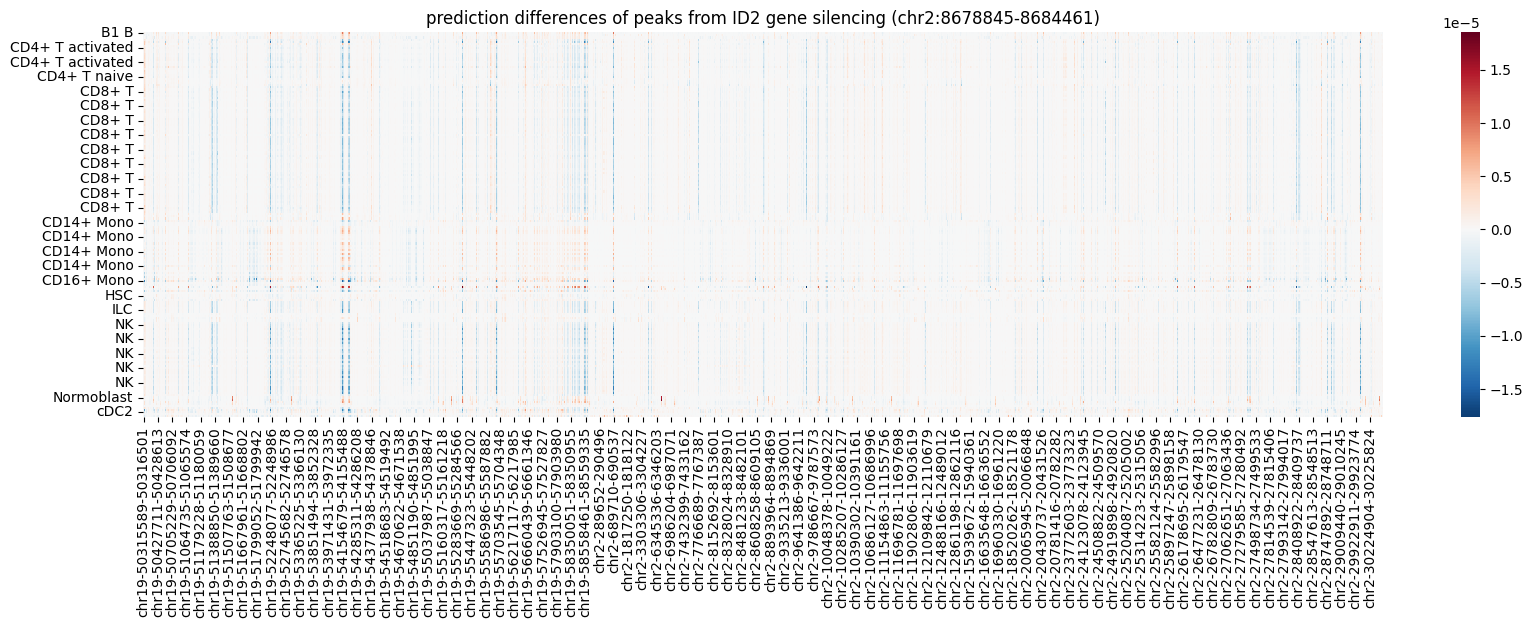

In [14]:
peak_id = 57602 # and the one before and after, but not too relevant for plotting
start_peak = peak_id - 1000
end_peak = peak_id + 1000
modality_switch = delta_gex.shape[1]

cell_types = test_set.obs['cell_type'].values[samples_of_interest]
heatmap_1 = delta_atac[:,start_peak:end_peak]

df_heatmap_1 = plot_gel(test_set, heatmap_1, gene_name, gene_location, modality_switch, start_peak, end_peak, cell_types)